# Approximate Nearest Neighbours Search

Sometimes, when we are processing a user query, it may be **acceptable to retrieve a "good guess"** of 
nearest neighbours to the query **instead of true nearest neighbours**. In those cases, one can use an algorithm which doesn't guarantee to return the actual nearest neighbour in every case, **in return for improved speed or memory savings**. Thus, with the help of such algorithms one can do a **fast approximate search in a very large dataset**. Today we will expore two approaches based on graphs and trees.

This is what we are going to do in this lab: 

1. Build a *navigable* small-world graph;
2. Build a k-d tree;
3. Try `Annoy`. 

# 0. Dataset preparation
We will utilize [dataset with curious facts](https://raw.githubusercontent.com/IUCVLab/information-retrieval/main/datasets/facts.txt). Using trained `doc2vec` [model](https://github.com/jhlau/doc2vec) (Associated Press News DBOW (0.6GB), we will infer vectors for every fact and normalize them.

## 0.1. Loading doc2vec model

In [5]:
# For some reason works only with 3.8.3
!pip install gensim==3.8.3

  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


  Using cached Cython-0.29.14-cp38-cp38-win_amd64.whl (1.7 MB)
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Can't uninstall 'Cython'. No files were found to uninstall.


In [7]:
#Had some warnings in gensim
!pip install python-Levenshtein

  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp38-cp38-win_amd64.whl size=83738 sha256=37e449c2158c11135cc189094c9f1870be52eba07e58aa4fb3d280f41df21798
  Stored in directory: c:\users\pavel\appdata\local\pip\cache\wheels\d7\0c\76\042b46eb0df65c3ccd0338f791210c55ab79d209bcc269e2c7
Successfully built python-Levenshtein


In [1]:
# Ignoring warnings. Will be handy later on
import warnings
warnings.filterwarnings('ignore')

In [2]:
from gensim.models.doc2vec import Doc2Vec

# unpack a model into 3 files and target the main one
# doc2vec.bin  <---------- this
# doc2vec.bin.syn0.npy
# doc2vec.bin.sin1neg.npy
model = Doc2Vec.load('doc2vec.bin', mmap=None)
print(type(model))
print(type(model.infer_vector(["to", "be", "or", "not"])))

<class 'gensim.models.doc2vec.Doc2Vec'>
<class 'numpy.ndarray'>


## 0.2. Reading data

In [3]:
import urllib.request
data_url = "https://raw.githubusercontent.com/IUCVLab/information-retrieval/main/datasets/facts.txt"
file_name= "facts.txt"
urllib.request.urlretrieve(data_url, file_name)

facts = []
with open(file_name) as fp:
    for cnt, line in enumerate(fp):
        facts.append(line.strip('\n'))

## 0.3. Transforming sentences into vectors

In [4]:
import nltk
import numpy as np

def word_tokenize(sentence):
    return nltk.word_tokenize(sentence.lower())

def get_words_from_sentence(sentences):
    for sentence in sentences: 
        yield word_tokenize(sentence.split('.', 1)[1])

sent_vecs = np.array([])
sent_vecs = np.array(list(model.infer_vector(words) for words in get_words_from_sentence(facts)))

## 0.4. Norming vectors (not graded)

Complete the method of vector norming, you can copy your code from previous homework.

In [5]:
def norm_vectors(A):
    # Copied from the previous HW
    An = (A.copy())
    length = np.sqrt(((An)**2).sum(axis=1))
    # https://stackoverflow.com/questions/19602187/numpy-divide-each-row-by-a-vector-element
    # Column-wise numpy deletion (15.04.2021)
    return An/length[:, None]

def find_k_closest(query, dataset, k=5):    
    index = list((i, v, np.dot(query, v)) for i, v in enumerate(dataset))    
    return sorted(index, key=lambda pair: pair[2], reverse=True)[:k]

sent_vecs_normed = norm_vectors(sent_vecs)

In [6]:
sent_vecs_normed.shape

(159, 300)

# 1. [40] Implementing Navigable Small World graph search

Now you need to implement an efficient search procedure which would utilize small world properties. Starting from the random node, at each step you should move towards the closest node (in terms of **cosine simiarity**, in our case), meanwhile keeping and refreshing top-K nearest neighbours collection. 

## 1.1. [35] Complete NSW index construction stage for this implementation

You can refer to the `Nearest_Neighbor_Insert` algorithm which pseudocode is given in section 5 (p. 65) of the [original paper](https://publications.hse.ru/mirror/pubs/share/folder/x5p6h7thif/direct/128296059).

In [7]:
import random
import sortedcontainers
import numpy as np
from scipy.spatial import distance
from numpy.linalg import norm as vector_norm
import pickle

class Node:
    ''' Graph node class. Major properties are `value` to access embedding and `neighbourhood` for adjacent nodes '''
    def __init__(self, value, idx, label):
        ### value -- vector, representing the item
        ### idx -- index in the item in the dataset
        ### label -- additional information, e.g. class label, content, ...
        ### self.neighbourhood -- set of id-s of neigbours
        self.value = value
        self.label = label
        self.idx = idx
        self.neighbourhood = set()
        
    def __repr__(self):
        return f"`#{self.idx}: '{self.label} ~ {self.value}' ~ [{self.neighbourhood}]`"
        
class NSWGraph:    
    ## NB: by default constructor uses euclidean distance
    ## Next block asks you to implement cosine distance
    def __init__(self, values=None, dist=None):
        '''Values are tuples or lists of (vector, label)'''
        self.dist = dist if dist else self.eucl_dist
        self.nodes = [Node(node[0], i, node[1]) for i, node in enumerate(values)] if values else []

    def eucl_dist(self, v1, v2) -> float:
        return distance.euclidean(v1, v2)
          
    def search_nsw_basic(self, query, visitedSet, candidates, result, top=5, guard_hops=100, callback=None):
        ''' basic algorithm, takes vector query and returns a pair (nearest_neighbours, hops)'''
        # ''' query -- vector-like, e.g. np.array ''' 
        # ''' visitedSet -- set of visited indices '''
        # ''' candidates -- sorted list of pairs (distance, index) '''
        # ''' result -- current state of closest neighbours, sorted container '''
        
        # taking random node as an entry point
        tmpResult = sortedcontainers.SortedList()
        entry = random.randint(0, len(self.nodes) - 1)
        if entry not in visitedSet:
            candidates.add((self.dist(query, self.nodes[entry].value), entry))
        tmpResult.add((self.dist(query, self.nodes[entry].value), entry))
        
        hops = 0
        while hops < guard_hops:
            hops += 1
            if len(candidates) == 0: break
            
            # 6 get element c closest from candidates (see paper 4.2.)
            # 7 remove c from candidates
            closest_dist, сlosest_id = candidates.pop(0)
            
            # k-th best of global result
            # new stop condition from paper
            # if c is further than k-th element from result
            # than break repeat
            #! NB this statemrnt from paper will not allow to converge in first run.
            #! thus we use tmpResult if result is empty
            if len(result or tmpResult) >= top:
                if (result or tmpResult)[top-1][0] < closest_dist: break

            #  for every element e from friends of c do:
            for e in self.nodes[сlosest_id].neighbourhood:
                # 13 if e is not in visitedSet than
                if e not in visitedSet:                   
                    d = self.dist(query, self.nodes[e].value)
                    # 14 add e to visitedSet, candidates, tempRes
                    visitedSet.add(e)
                    candidates.add((d, e))
                    tmpResult.add((d, e))
                    
            if callback is not None:
                callback(self.nodes[сlosest_id].value, tmpResult)

        return tmpResult, hops
        
    def multi_search(self, query, attempts=1, top=5):   
        '''Implementation of `K-NNSearch`, but without keeping the visitedSet'''

        # share visitedSet among searched. Paper, 4.2.p2
        visitedSet, candidates, result = set(), sortedcontainers.SortedList(), sortedcontainers.SortedList()
        
        for i in range(attempts):
            closest, hops = self.search_nsw_basic(query, visitedSet, candidates, result, top=top)
            result.update(closest)
            result = sortedcontainers.SortedList(set(result))
            
        return [v for k, v in result[:top]]
    
    ####################################
    ##   COMPLETE THIS METHOD         ##
    ####################################
    def build_navigable_graph(self, values, attempts=3, verbose=False, M=None):
        '''Accepts container with values. Returns list with graph nodes'''
        
        # values -- list of any array-like structure consisting of pairs (vector, label)
        
        
        # create graph with one node
        self.nodes.append(Node(values[0][0], len(self.nodes), values[0][1]))
        
        # The tests indicate [36] that at least for Euclid data with
        # d = 1...20, the optimal value for number of neighbors to
        # connect (f) is about 3d
        d = len(values[0][0])
        f = 3 * d if M is None else M
        if verbose:
            print(f"Data dimensionality detected is {d}. regularity = {f}")
        
        ##################################
        ### TODO implement this part:                                    #
        ### 1. Repeat for each node                                      #
        ### 2. Search for f neighbours with `attempts` value             #
        ### 3. Create a node, insert in a list and connect it to obtained#
        ### Use node.neighbourhood property to store neighbour indices   #
        ##################################
        self.nodes[0].neighbourhood = []
        for i in range(1, len(values)):
            val = values[i][0]
            
            ## SOME CODE IS MISSING HERE
            
            node = Node(values[i][0], len(self.nodes), values[i][1])
            node.neighbourhood = self.multi_search(val, attempts, f)
            for n in node.neighbourhood:
                neighbour = self.nodes[n]
                neighbour.neighbourhood.append(node.idx)
            self.nodes.append(node)
            
            
            if verbose:
                if i * 10 % len(values) == 0:
                    print(f"\t{100 * i / len(values):.2f}% of graph construction")

## 1.2. [5] Implement cosine distance

In [8]:
from scipy.spatial.distance import cosine as cos
import sys

def cosine(a, b) -> float:
    ## implement cosine-based metric for a pair of vectors (which can be just lists)
    # https://stackoverflow.com/questions/26699659/cosine-similarity-when-one-of-vectors-is-all-zeros
    if np.array(a).sum() == 0 and np.array(b).sum() == 0:
        return 1 - cos(np.array(a)+10**(-10), np.array(b)+10**(-10)) 
    if np.array(a).sum() == 0:
        return 1 - cos(np.array(a)+10**(-10), b) 
    elif np.array(b).sum() == 0:
        return 1 - cos(a, np.array(b)+10**(-10))
    return 1 - cos(a, b) 

## 1.3. Test your search engine

In [9]:
g = NSWGraph(dist=cosine)

# data contains pairs of (vector, label)

data = [([0, 0], "a"), ([0, 0], "a"), ([100, 101], "b"), ([100, 100], "b")]
data += [([1, 0], "a"), ([1, 0], "a"), ([101, 101], "b"), ([101, 100], "b")]
data += [([2, 0], "a"), ([2, 0], "a"), ([102, 101], "b"), ([102, 100], "b")]
data += [([3, 0], "a"), ([3, 0], "a"), ([103, 101], "b"), ([104, 100], "b")]
g.build_navigable_graph(data, verbose=True)

q = [0, 0]
print(f"Searching for {q}:")

for idx in g.multi_search([0, 0]):
    print(idx, g.nodes[idx])
    assert g.nodes[idx].value[0] < 10 and g.nodes[idx].value[1] < 10, f"{g.nodes[idx]} is not close to {q}"

Data dimensionality detected is 2. regularity = 6
	50.00% of graph construction
Searching for [0, 0]:
12 `#12: 'a ~ [3, 0]' ~ [[2, 0, 1, 3, 6, 10, 14, 15]]`
13 `#13: 'a ~ [3, 0]' ~ [[2, 0, 1, 3, 6, 10, 14, 15]]`
4 `#4: 'a ~ [1, 0]' ~ [[2, 3, 0, 1, 5, 6, 7, 10, 11, 14, 15]]`
5 `#5: 'a ~ [1, 0]' ~ [[2, 3, 0, 1, 4, 6, 7, 10, 11, 14, 15]]`
8 `#8: 'a ~ [2, 0]' ~ [[2, 3, 0, 1, 6, 7, 10, 11, 14, 15]]`


## 1.4. [Bonus] Visualize the graph

Draw a picture with NSW graph with 100 2D nodes distributed uniformly in `[0, 1] x [0, 1]` range. Use `matplotlib` or `seaborn` or whatever.

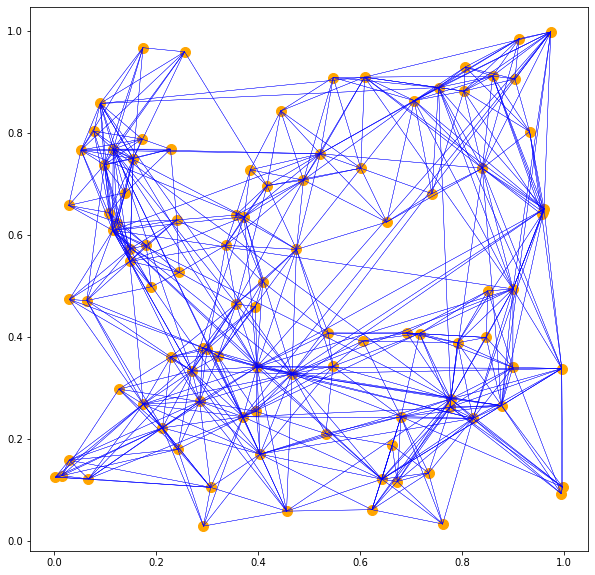

In [10]:
## your code here!
from matplotlib import pyplot as plt
import random

dataset = [([random.uniform(0.0, 1.0), random.uniform(0.0, 1.0)], 'label') for x in range(100)]
g = NSWGraph()
plt.figure(figsize=[10, 10])
g.build_navigable_graph(dataset)
for i in range(len(g.nodes)):
    node = g.nodes[i]
    for j in range(len(node.neighbourhood)):
        neighbour = g.nodes[node.neighbourhood[j]]
        plt.plot([node.value[0], neighbour.value[0]], [node.value[1], neighbour.value[1]], color ='blue', linewidth=0.35)
    plt.scatter(node.value[0], node.value[1], s=100, color='orange')

# 2. [60] Implement KD-tree

Within this part you will iteratively implement major methods of [kd-tree](https://en.wikipedia.org/wiki/K-d_tree) data structure. Biggest part of code is already written - just fill remaining gaps. 

This particular implementation is designed to be **non-homogeneous**, which means it **stores values only in leaf nodes**. But this doesn't limit you if you want to implement another approach.

Each leaf node can hold up to `leaf_capacity` items.

Item stored in an index is a tuple: `(coordinate_k_dim_vector, value)`.

Search requires only `coordinate_k_dim_vector` and returns relevant item(s).

## 2.0. Data generation

In [7]:
import time
import numpy as np 
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

K_random = 10
maxsize = 500000
start = time.time()
R = np.random.rand(maxsize, K_random)
R = [(row, "stub value {}".format(i)) for i, row in enumerate(R)]
print(R[:3])
finish = time.time()
print("{} rows generated in {:.2f} s".format(len(R), finish - start))

[(array([0.00846239, 0.59622536, 0.63040279, 0.3421649 , 0.65686838,
       0.69256033, 0.14048318, 0.06984826, 0.01805594, 0.30576629]), 'stub value 0'), (array([0.24701258, 0.29334025, 0.02051033, 0.85775911, 0.62354615,
       0.39879837, 0.8799456 , 0.45250244, 0.78521794, 0.24489533]), 'stub value 1'), (array([0.98904858, 0.20152691, 0.64109532, 0.89276388, 0.77844478,
       0.29993123, 0.28669267, 0.80168953, 0.50019622, 0.00360798]), 'stub value 2')]
500000 rows generated in 0.39 s


## 2.1. Build procedure ##
`build_kd_tree()` method implements the core idea. This is the suggested idea, but you can modify it slightly:
- tree is non-homogenous, thus, items are stored in leaf nodes only.
- `self.pivot` should be assigned the median value for correspoinding `depth % K` coordinate.
- `left` variable should hold all the items <= than `self.pivot`.
- `right` variable should hold all the items > than `self.pivot`.
- `node_capacity=X` allows to store up to `X` items in a leaf node.

This is how it works for `K=2, node_capacity=2`:
![kd-tree](http://sprotasov.ru/files/kd.png)

## 2.2. [20+15+15+10] Complete the following methods
- `build_kd_tree`, 
- `kd_find_leaf`,
- `kd_insert_with_split`,
- `get_nn`

Test for each of them will come in following blocks.

In [10]:
a = np.array(R)

<ipython-input-10-60dfdf3d1303>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(R)


In [8]:
import numpy as np
from scipy.spatial import distance
afrom queue import Queue

class Node:
    def __init__(self, K=None, parent=None):
        assert K is not None or parent, "Either `K` should be provided for root node, or `parent` for internal nodes"
        # Reference to parent node. Used in ANNS search
        self.parent = parent
        # depth start from 0. To compute dimension, relevant to the level, use (self.depth % self.K)
        self.depth = (parent.depth + 1) if parent else 0
        # K means number of vector dimensions
        self.K = parent.K if parent else K
        # value, which splits subspace into to parts using hyperplane: item[self.depth % self.K] == self.pivot
        # pivot is empty for any leaf node.
        self.pivot = None
        # left and right child nodes
        self.left = None
        self.right = None
        # collection of items
        self.items = None
        
    def build_kd_tree(self, items, leaf_capacity=4):
        '''Takes a list of items and arranges it in a kd-tree'''
        assert items is not None, "Please provide at least one point"
        # put all items in the node if they fit into limit
        if len(items) <= leaf_capacity:
            self.items = items
        # or else split items into 2 subnodes using median (?!) value
        else:
            self.items = None
            self.left = Node(parent=self)
            self.right = Node(parent=self)
            
            #TODO 1.A.: fill in the code to initialize internal node.
            # Be careful: there may be multiple items with the same values as pivot,
            # make sure they go to the same child.
            # Also, there may be duplicate items, and you need to deal with them
            # This attribute in non-leaf elements will become handy when retrieving knn
            self.total = len(items)
            arr = []
            dup = 0
            for i in range(len(items)):
                # Extracting array from items
                if (items[i][0] == items[i-1][0]).all():
                    dup = dup + 1
                arr.append(items[i][0])
            it = np.array(arr)
            # Finding mean
            self.pivot = it[:, self.depth % self.K].mean()   # here you should write median value with respect to coordinate
            # If all of the items are duplicates - split them into 2, else, split by median value
            left = list(filter(lambda x: x[0][self.depth % self.K] <= self.pivot, items)) if dup+1 != len(it) else items[:(len(items)//2)]           # those items, which are smaller than the pivot value
            right = list(filter(lambda x: x[0][self.depth % self.K] > self.pivot, items)) if dup+1 != len(it) else items[(len(items)//2):]         # those items, which are greater than the pivot value
            
            
            self.left.build_kd_tree(left)
            self.right.build_kd_tree(right)

        return self
    
    def kd_find_leaf(self, key):
        ''' returns a node where key should be stored (but can be not present)'''
        if self.pivot is None or self.items is not None: # leaf node OR empty root
            return self
        else:
            
            #TODO 1.B. This is a basic operation for travesing the tree.
            # define correct path to continue recursion
            
            return self.left.kd_find_leaf(key) if key[self.depth % self.K] <= self.pivot else self.right.kd_find_leaf(key)
            
      ## NB you can use this code as a starting point for insertion with split      
#     def kd_insert_no_split(self, item):
#         '''Naive implementation of insert into leaf node. It is not used in tests of this tutorial.'''
#         node = self.kd_find_leaf(item[0])
#         node.items.append(item)
        
    def kd_insert_with_split(self, item, leaf_capacity=4):
        '''This method recursively splits the nodes into 2 child nodes if they overflow `leaf_capacity`'''
        
        #TODO 1.C. This is very simple insertion procedure.
        # Split the node if it cannot accept one more item.
        # HINT: reuse kd_find_leaf() and build_kd_tree() methods if possible
        # If there are no Items in the beginning, build a tree of 1 item to the node
        if self.right == None and self.left == None and not self.items:
            self.build_kd_tree([item])
        else:
            # Else, append to leaf
            node = self.kd_find_leaf(item[0])
            node.items.append(item)
            # And divide in case there is no space
            if len(node.items) > leaf_capacity:
                node.build_kd_tree(node.items, leaf_capacity)
                node.items = None
    
    def bfs(self, node):
        # https://en.wikipedia.org/wiki/Breadth-first_search
        # Iterative BFS
        if node.left == None and node.right == None:
            return node.items
        results = []
        nodes = Queue()
        nodes.put(node)
        while not nodes.empty():
            n = nodes.get()
            if n.left == None and n.right == None:
                results += n.items
            else:
                nodes.put(n.left)
                nodes.put(n.right)
        return results
            
    
    def get_nn(self, key, knn):
        '''Return K approximate nearest neighbours for a given key'''
        node = self.kd_find_leaf(key)
        elements = len(node.items)
        # If there is not enough elements to suffice search in leaf - go higher
        while elements < knn and node.parent != None:
            node = node.parent
            elements = node.total
        best = self.bfs(node)
        # Sorting by distance
        best.sort(key=lambda x: distance.euclidean(x[0], key))
        # If, overall, there are less elements in the tree than knn - return all the elements
        return best[:knn] if len(best) > knn else best
        
        #TODO 1.D. ANN search.
        # write here the code which returns `knn` 
        # approximate nearest neighbours with respect to euclidean distance
        # basically, you need to move up through the parents chain until the number of elements
        # in a parent subtree is more or equal too the expected number of nearest neighbors,
        # and then return top-k elements of this subtree sorted by euclidean distance
        # HINT: you can use [scipy.spatial.]distance.euclidean(a, c) - it is already imported
        
                
        return best[:knn]

### 2.2.1. Test that building time is growing linearly

In [4]:
import tqdm

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:10<00:00, 13.01s/it]


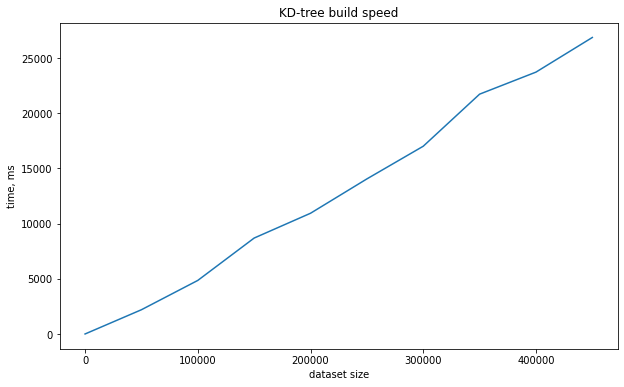

In [9]:
# sample 10, 20, ..., 100% of R
step = len(R) // 10
sizes, build_times = [], []

# tqdm_notebook draws a progress bar. If it doesnt't work in your environment, just remove it.
for size in tqdm.tqdm(range(1, len(R) + 1, step)):
    sample = R[:size]
    start = time.time()
    kdtree = Node(K=K_random).build_kd_tree(sample)
    finish = time.time()
    sizes.append(size)
    build_times.append((finish - start) * 1000)
    
    
fig = plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('dataset size')
a.set_ylabel('time, ms')
plt.plot(sizes, build_times)
plt.title("KD-tree build speed")
plt.show()

### 2.2.2. Test that search time is fast and of a millisecond scale

  0%|          | 0/10 [00:00<?, ?it/s]

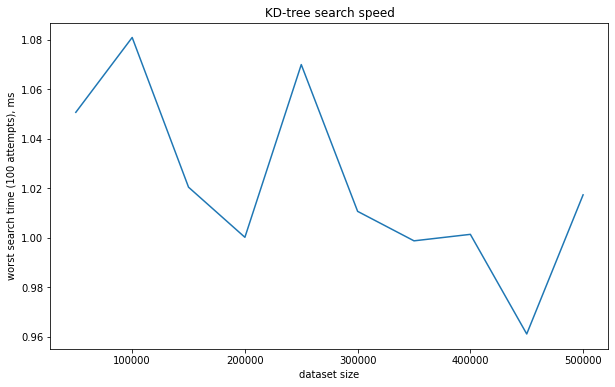

In [14]:
step = len(R) // 10
sizes, search_times = [], []

for size in tqdm_notebook(range(step, len(R) + 1, step)):
    kdtree = Node(K=K_random).build_kd_tree(R[:size])
    
    iterations = 100
    duration = None
    for i in range(iterations):
        x = R[random.randint(0, len(R) - 1)]
        start = time.time()
        kdtree.kd_find_leaf(x[0])
        finish = time.time()
        duration = max(duration, finish - start) if duration else finish - start
        
    sizes.append(size)
    search_times.append(duration * 1000)
    
    
fig = plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('dataset size')
a.set_ylabel('worst search time (100 attempts), ms')
plt.plot(sizes, search_times)
plt.title("KD-tree search speed")
plt.show()

### 2.2.3. Insertion ###
Inserting speed should be growing similar to `log` function with respect to data size.

Now let's see how fast the tree depth is growing for different capacity set-ups. Implement the remaining part of `kd_insert_with_split()` and run the test.

  0%|          | 0/100 [00:00<?, ?it/s]

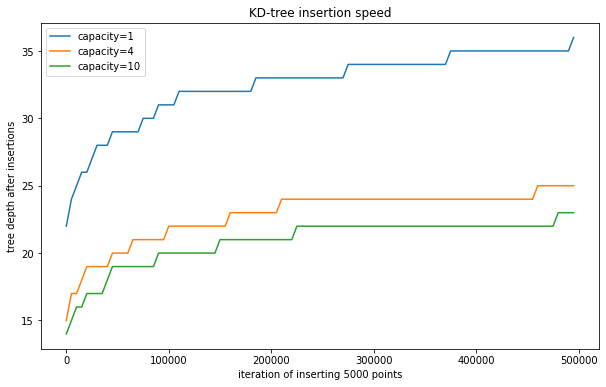

In [15]:
step = 5000
sample_size = 500000
trees = [
            Node(K=K_random), 
            Node(K=K_random), 
            Node(K=K_random)
]
capacities = [1, 4, 10]


sizes, depths = [], [[], [], []]
max_depth = [0, 0, 0]
for i in tqdm_notebook(range(0, sample_size, step)):
    for item in R[i:i+step]:
        for t in range(3):
            trees[t].kd_insert_with_split((item[0], "stub value test 1.C."), leaf_capacity=capacities[t])
            max_depth[t] = max(trees[t].kd_find_leaf(item[0]).depth, max_depth[t])
    sizes.append(i)
    for t in range(3):
        depths[t].append(max_depth[t])

fig = plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('iteration of inserting 5000 points')
a.set_ylabel('tree depth after insertions')
plt.plot(sizes, depths[0], label="capacity={}".format(capacities[0]))
plt.plot(sizes, depths[1], label="capacity={}".format(capacities[1]))
plt.plot(sizes, depths[2], label="capacity={}".format(capacities[2]))
plt.legend(loc="upper left")
plt.title("KD-tree insertion speed")
plt.show()

### 2.2.4. ANNS search ### 
This block tests `get_nn()` method, which performs approximate nearest neighbour search. Please, complete this method. After you run this block you will see how NN count influences search speed. It should be linear.

  0%|          | 0/6 [00:00<?, ?it/s]

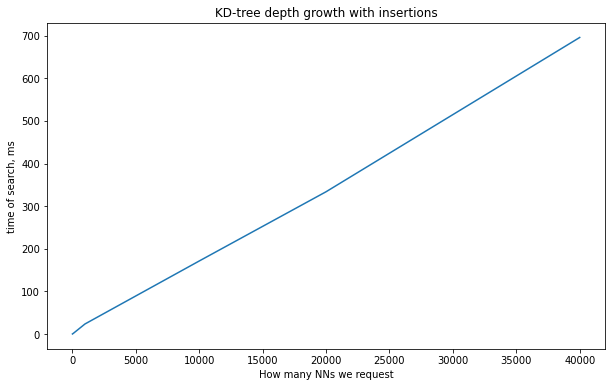

In [16]:
# NN SEARCH
kdtree = Node(K=K_random).build_kd_tree(R)
times = []
nns = [10, 100, 1000, 10000, 20000, 40000]
iterations = 10
for nn in tqdm_notebook(nns):
    start = time.time()
    for t in range(iterations):
        x = R[random.randint(0, len(R) - 1)]
        kdtree.get_nn(x[0], nn)
    finish = time.time()
    times.append((finish - start) * 1000 / iterations)

fig = plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('How many NNs we request')
a.set_ylabel('time of search, ms')
plt.title("KD-tree depth growth with insertions")
plt.plot(nns,times)
plt.show()

## 2.3. Real data (self studying)

Please refer to [this notebook](github.com/08%20Approximate%20NN%20Search%20trees%20template.ipynb#3.-Real-data) to see how the methods work with real data on a map.

# 3. [Bonus] [Annoy](https://github.com/spotify/annoy) library ## 

Now you have your own index data structure. How far is it from industrial implementations?

First of all, let's install and import the requirement. Just run it.

In [1]:
!pip install --user annoy

  Using cached annoy-1.17.0.tar.gz (646 kB)
  Created wheel for annoy: filename=annoy-1.17.0-cp38-cp38-win_amd64.whl size=52650 sha256=917fdeff2f3b1aa7ddcd6ed7fd62948e6ffc13f83603bbb95e3d83d8d5f5719d
  Stored in directory: c:\users\pavel\appdata\local\pip\cache\wheels\77\01\de\4421524f9997a25dfa7291121565d12ef514154945e80e907a
Successfully built annoy


In [17]:
from annoy import AnnoyIndex

## 3.1. Build the index upon the same data using 10 trees, cosine distance

In [18]:
trees = 10
dist = 'angular'
index = AnnoyIndex(len(R[0][0]), dist)
## WRITE YOUR CODE HERE
for i in range(len(R)):
    index.add_item(i, R[i][0])
index.build(trees)

True

Let's run a test for KNN search. 

Is it much faster?

Is it assimpotically faster?

  0%|          | 0/6 [00:00<?, ?it/s]

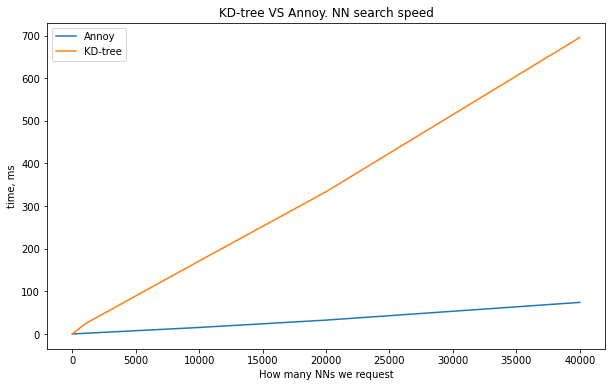

In [19]:
# NN SEARCH
times_annoy = []
nns = [10, 100, 1000, 10000, 20000, 40000]
iterations = 10
for nn in tqdm_notebook(nns):
    start = time.time()
    for t in range(iterations):
        x = R[random.randint(0, len(R) - 1)]
        index.get_nns_by_vector(x[0], nn)
    finish = time.time()
    times_annoy.append((finish - start) * 1000 / iterations)

fig = plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('How many NNs we request')
a.set_ylabel('time, ms')
plt.plot(nns, times_annoy, label='Annoy')
# you can also build times array on the same graph
plt.plot(nns, times, label='KD-tree')
plt.legend(loc="upper left")
plt.title("KD-tree VS Annoy. NN search speed")
plt.show()